In [1]:
import os
from io import BytesIO
from pathlib import Path
from tempfile import TemporaryDirectory
from multiprocessing import Pool
import numpy as np
import pandas as pd

In [3]:
import sys
sys.path.append('../src')

from command import run_cmd
from tree import calculate_distance, Dendrogram

In [ ]:
def accuracy(reference, assembly):
    with TemporaryDirectory(dir='/tmp/') as tmpdir:
        os.symlink(reference, os.path.join(tmpdir, 'reference.fa'))
        reference = os.path.join(tmpdir, 'reference.fa')
        
        os.symlink(assembly, os.path.join(tmpdir, 'assembly.fa'))
        assembly = os.path.join(tmpdir, 'assembly.fa')
        
        cmd = f'/home/chen1i6c04/Tools/assembly_accuracy/fastmer.py --reference {reference} --assembly {assembly}'
        stdout, stderr = run_cmd(cmd)
    return pd.read_csv(BytesIO(stdout), sep='\t')

In [ ]:
def accuracy_in_diff_steps(reference, dirpath):
    if isinstance(dirpath, Path) is False:
        dirpath = Path(dirpath)
    
    targets = {'flye': 'flye/assembly.fasta',
               'racon': 'racon.fasta',
               'medaka': 'medaka/consensus.fasta',
               'homopolish': 'homopolish/consensus_homopolished.fasta',}
    
    with Pool(4) as p:
        try:
            multi_results = [p.apply_async(accuracy, (reference, dirpath/j)) for i, j in targets.items()]
            multi_results = [result.get() for result in multi_results]
            multi_results = pd.concat(multi_results)
            multi_results['assembly_name'] = list(targets)
        except:
            p.terminate()
            
    return multi_results

In [29]:
denovo_path = Path('/media/NGS/Nanopore_1/20200925/denovo')
contig_path = Path('/media/NGS/Nanopore_1/20200925/contigs')

multiple_results = []
for i in contig_path.iterdir():
    result = accuracy_in_diff_steps(i, denovo_path/i.stem)
    result = result.pivot_table(values='segment_median_qscore', columns='assembly_name')
    result.index = [i.stem]
    multiple_results.append(result)

qscore = pd.concat(multiple_results)
qscore = qscore[['flye', 'racon', 'medaka', 'homopolish']].sort_index()
qscore.index.name = 'Key'

In [30]:
qscore

assembly_name,flye,racon,medaka,homopolish
Key,,,,
R19-2905,32.56,33.52,39.39,46.99
R20-0026,25.33,24.47,25.36,26.81
R20-0030,25.75,25.59,26.52,28.77
R20-0088,34.56,35.23,45.23,50.00
R20-0127,26.40,26.22,27.41,29.17
R20-0131,34.69,35.23,45.23,50.00
R20-0140,33.82,34.42,40.00,90.00
R20-0145,33.98,34.56,42.22,50.00
R20-0148,26.92,26.94,28.17,30.11


In [15]:
samples = ('R20-0148', 'R20-0127', 'R20-0131', 'R20-0026', 'R20-0158', 'R19-2905', 'R20-0145', 'R20-0140',
           'R20-0160', 'R20-0088', 'R20-0030', 'R20-0150')

dirpath = Path('/media/NGS/Data_Analysis/20201221_nanopore_assembly_in_hybrid_and_denovo/Profile/1_chip_n_strains')
df = []
for sample in samples:
    profiles = pd.concat([pd.read_csv(i, header=0, index_col=0, names=[i.stem], sep='\t')
                          for i in dirpath.iterdir() if i.stem.startswith(sample)], axis=1)
    pdist = calculate_distance(profiles)
    pdist.index = pdist.index.str.split('_').str[-1]
    pdist.columns = pdist.columns.str.split('_').str[-1]
    s = pdist.loc['unicycler']
    s.name = sample
    df.append(s)

distance = pd.concat(df, axis=1).T
distance = distance[['flye', 'racon', 'medaka', 'homopolish',]].sort_index()
distance.index.name = 'Key'
distance

,flye,racon,medaka,homopolish
Key,,,,
R19-2905,630.0,473.0,123.0,21.0
R20-0026,1595.0,1566.0,1476.0,1336.0
R20-0030,1590.0,1489.0,1385.0,1080.0
R20-0088,425.0,355.0,44.0,5.0
R20-0127,1503.0,1375.0,1269.0,1070.0
R20-0131,400.0,347.0,36.0,2.0
R20-0140,512.0,429.0,122.0,3.0
R20-0145,506.0,448.0,68.0,4.0
R20-0148,1431.0,1258.0,1147.0,1073.0


In [ ]:
dirpath = Path('/media/NGS/Nanopore_1/20200925/fastq')

In [ ]:
depth = []
for i in dirpath.iterdir():
    stdout, stderr = run_cmd(f"seqtk fqchk {i} | grep ALL | awk '{{print $2}}'")
    total_bases = int(stdout.decode().strip())
    depth.append((i.stem, round(total_bases/3000000)))

In [ ]:
depth = pd.DataFrame(depth, columns=['Key', 'depth'])

In [ ]:
depth = depth.sort_values('Key')

In [ ]:
with pd.ExcelWriter('assembly_accuracy.xlsx') as writer:
    qscore.to_excel(writer, sheet_name='Q-Score')
    distance.to_excel(writer, sheet_name='cgMLST distance')
    depth.to_excel(writer, sheet_name='depth', index=False)

In [17]:
strain_names = ('R20-0148', 'R20-0127', 'R20-0131', 'R20-0026', 'R20-0158', 'R19-2905',
                'R20-0145', 'R20-0140', 'R20-0160', 'R20-0088', 'R20-0030', 'R20-0150')

In [19]:
hybrid_path = Path('/media/NGS/Nanopore_1/20200925/contigs/hybrid')
denovo_path = Path('/media/NGS/Nanopore_1/20200925/contigs/denovo/')
outpath = Path('/media/NGS/Nanopore_1/20200925/quast')

In [20]:
for strain_name in strain_names:
    ref_file = hybrid_path/(strain_name + '.fa')
    in_file = denovo_path/(strain_name + '.fa')
    outdir = outpath/strain_name
    cmd = f'conda run -n quast quast.py -r {ref_file} -o {outdir} --circos -u {in_file}'
    run_cmd(cmd)

In [16]:
dirpath = Path('/media/NGS/Nanopore_1/20200925/denovo')
# reports = []
# for i in dirpath.iterdir():
#     filepath = i/'quast'/'report.tsv'
#     report = pd.read_csv(filepath, sep='\t', index_col=0, header=0, names=[i.name])
#     reports.append(report)
# reports = pd.concat(reports, axis=1)

is_circ = dict()
for i in dirpath.iterdir():
    filepath = i/'flye'/'assembly_info.txt'
    assembly_info = pd.read_csv(filepath, sep='\t')
    if all(assembly_info['circ.'] == 'Y'):
        is_circ[i.name] = 'Y'
    else:
        is_circ[i.name] = 'N'

In [17]:
is_circ

{'R20-0148': 'Y',
 'R20-0127': 'Y',
 'R20-0131': 'Y',
 'R20-0026': 'Y',
 'R20-0158': 'Y',
 'R19-2905': 'Y',
 'R20-0145': 'Y',
 'R20-0140': 'N',
 'R20-0160': 'Y',
 'R20-0088': 'Y',
 'R20-0030': 'Y',
 'R20-0150': 'Y'}

In [58]:
dirpath_ls = {'R18-0877': Path('/media/NGS/Nanopore_1/20181127_R18-0877/denovo'),
              'R19-2839': Path('/media/NGS/Nanopore_1/20190917_R19_2839/denovo'),
              'R18-0926': Path('/media/NGS/Nanopore_1/20181205_R18-0926/denovo')}

reports = []
for i, j in dirpath_ls.items():
    filepath = j/'quast'/'report.tsv'
    report = pd.read_csv(filepath, sep='\t', index_col=0, header=0, names=[i])
    reports.append(report)
reports = pd.concat(reports, axis=1)

is_circ = dict()
for i, j in dirpath_ls.items():
    filepath = j/'flye'/'assembly_info.txt'
    assembly_info = pd.read_csv(filepath, sep='\t')
    if all(assembly_info['circ.'] == 'Y'):
        is_circ[i] = 'Y'
    else:
        is_circ[i] = 'N'

reports.loc['circ'] = reports.columns.map(is_circ)

In [60]:
with pd.ExcelWriter('chip_single_strain_assembly_accuracy.xlsx') as writer:
    distance.to_excel(writer, sheet_name='cgmlst distance')
    reports.to_excel(writer, sheet_name='quast report')

# use different flowcell

In [43]:
dna_r10 = accuracy_in_diff_steps('/media/NGS/Nanopore_1/20191021_with_R10/2_unicycler_R10_R19-2839/assembly.fasta',
                                 '/media/NGS/Nanopore_1/20191021_with_R10/denovo/R19-2839')
dna_r10 = dna_r10.pivot_table(values='segment_median_qscore', columns='assembly_name')
dna_r10.index = ['r10']

In [45]:
dna_r9 = accuracy_in_diff_steps('/media/NGS/Nanopore_1/20190917_R19_2839/2_unicycler/assembly.fasta',
                                '/media/NGS/Nanopore_1/20190917_R19_2839/denovo/R19-2839')
dna_r9 = dna_r9.pivot_table(values='segment_median_qscore', columns='assembly_name')
dna_r9.index = ['r9']

In [47]:
qscore = pd.concat([dna_r9, dna_r10])

In [72]:
qscore = qscore[['flye', 'racon', 'medaka', 'homopolish']]

In [75]:
dirpath = Path('/media/NGS/Data_Analysis/20201221_nanopore_denovo/Profile/1_chip_1_strain')
profiles = pd.concat([pd.read_csv(i, header=0, index_col=0, names=[i.stem], sep='\t')
                      for i in dirpath.iterdir() if i.stem.startswith("R19-2839-R9")], axis=1)
pdist = calculate_distance(profiles)
pdist.index = pdist.index.str.split('_').str[-1]
pdist.columns = pdist.columns.str.split('_').str[-1]
s_r9 = pdist.loc[['unicycler']]

In [76]:
dirpath = Path('/media/NGS/Data_Analysis/20201221_nanopore_denovo/Profile/1_chip_1_strain')
profiles = pd.concat([pd.read_csv(i, header=0, index_col=0, names=[i.stem], sep='\t')
                      for i in dirpath.iterdir() if i.stem.startswith("R19-2839-R10")], axis=1)
pdist = calculate_distance(profiles)
pdist.index = pdist.index.str.split('_').str[-1]
pdist.columns = pdist.columns.str.split('_').str[-1]
s_r10 = pdist.loc[['unicycler']]

In [77]:
s_r9.index = ['r9']
s_r10.index = ['r10']

In [78]:
distance = pd.concat([s_r9, s_r10])

In [79]:
distance = distance[['flye', 'racon', 'medaka', 'homopolish']]

In [81]:
with pd.ExcelWriter('R19-2839_assembly_accuracy.xlsx') as writer:
    qscore.to_excel(writer, sheet_name='Q-Score')
    distance.to_excel(writer, sheet_name='cgMLST distance')

In [14]:
labels_color = {'R20-0026': 'red', 'R20-0030': 'red', 'R20-0127': 'red', 'R20-0148': 'red', 'R20-0150': 'red'}

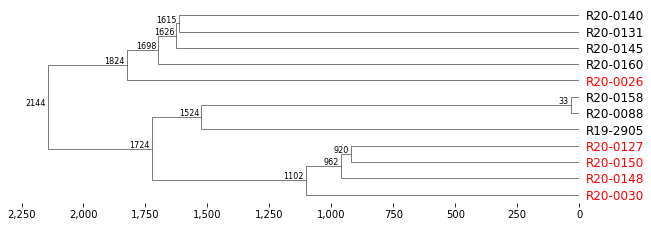

In [15]:
dirpath = Path('/media/NGS/Nanopore_1/20200925/cgMLST_profile/denovo')

profiles = pd.concat([pd.read_csv(i, sep='\t', index_col=0, header=0, names=[i.stem.split('_')[0]]) for i in dirpath.iterdir()], axis=1)

pdist = calculate_distance(profiles)

dendrogram = Dendrogram(pdist)
dendrogram.cluster(show_node_info=True, labels_color=labels_color)
dendrogram.figure

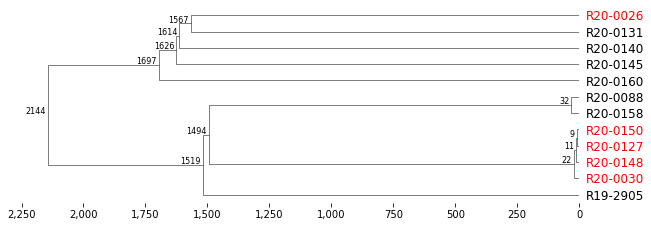

In [16]:
dirpath = Path('/media/NGS/Nanopore_1/20200925/cgMLST_profile/hybrid/')

profiles = pd.concat([pd.read_csv(i, sep='\t', index_col=0, header=0, names=[i.stem.split('_')[0]]) for i in dirpath.iterdir()], axis=1)

pdist = calculate_distance(profiles)

dendrogram = Dendrogram(pdist)
dendrogram.cluster(show_node_info=True, labels_color=labels_color)
dendrogram.figure